In [1]:
import copy
import os
import pickle
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset

from utils.options import args_parser
from utils.train_utils import get_data, get_model
from models.Update import DatasetSplit
from models.test import test_img_local, test_img_local_all, test_img_global

import pdb
import easydict

import sys

In [2]:
def record_net_data_stats(net_dataidx_map, all_targets):
    net_cls_counts = {}#각 client가 어떤 label을 몇개씩 가지고 있는지 통계량 기재!!

    for net_i, dataidx in net_dataidx_map.items():
        unq, unq_cnt = np.unique(all_targets[dataidx], return_counts=True)#전체 train data 중에 net_i번째 client가 가지고 있는 data가 어떤 label을 가지고 있는지의 정보가 unq, unq의 각 element가 몇개 들어있는지 기재하는게 unq_count이다!!
        tmp = {unq[i]: unq_cnt[i] for i in range(len(unq))}#tmp에는 unq가 key unq_count가 value가 되게 기재!!
        net_cls_counts[net_i] = tmp
    return net_cls_counts #각 client가 어떤 label을 몇개씩 가지고 있는지 통계량 기재!!

In [3]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for shard_per_user in [2]:
    for frac in [0.1]:
        for local_ep in [15]:
            for local_upt_part, aggr_part in [('body', 'body')]:
                args = easydict.EasyDict({'epochs': local_ep,
                                          'num_users': 100,
                                          'shard_per_user': shard_per_user,
                                          'server_data_ratio': server_data_ratio,
                                          'frac': frac,
                                          'local_ep': local_ep,
                                          'local_bs': 500,
                                          'bs': 50,
                                          'lr': 0.01,
                                          'momentum': momentum,
                                          'wd': wd,
                                          'model': model,
                                          

                                          'dataset': dataset,
                                          'iid': False,
                                          'num_classes': num_classes,
                                          'gpu': 0,
                                          'verbose': False,
                                          'seed': 1,
                                          'test_freq': 1,
                                          'load_fed': '',
                                          'results_save': 'run1',
                                          'local_upt_part': local_upt_part,
                                          'aggr_part': aggr_part,
                                          'feature_norm': 1,
                                          'fn': False,
                                          'hetero_option': "shard"
                                          })

                # parse args
                args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
                base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/shard{}/decay_0.1/fn_{}/seed_0/FedAvg'.format(
                    args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd,args.shard_per_user, args.fn)
                algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)
                
 
                dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)
    
                test_dataloader = DataLoader(dataset_test, batch_size=args.bs, shuffle=False)
   

                # build model
                model = get_model(args)
                model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                model.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                
                model.eval()


                # 클래스별로 예측 성공한 데이터와 예측 실패한 데이터의 개수를 저장할 리스트를 생성합니다.
                success_counts = [0 for _ in range(10)]
                failure_counts = [0 for _ in range(10)]

                # 클래스별로 softmax 확률을 누적할 리스트를 생성합니다.
                success_prob_sums = [torch.zeros(10).to(args.device) for _ in range(10)]
                failure_prob_sums = [torch.zeros(10).to(args.device) for _ in range(10)]
                
                # 클래스별로 정확한 예측 수를 저장할 리스트를 생성합니다.
                accuracies = [0 for _ in range(10)]


                # 각 데이터의 예측 결과를 확인하고 클래스별로 softmax 확률을 누적합니다.
                with torch.no_grad():
                    for images, labels in test_dataloader:
                        if args.gpu != -1:
                            images, labels = images.to(args.device), labels.to(args.device)

                        outputs = model(images)
                        softmax_probs = torch.nn.functional.softmax(outputs, dim=1)

                        predicted_labels = torch.argmax(softmax_probs, dim=1)

                        for i in range(len(labels)):
                            label = labels[i].item()
                            predicted_label = predicted_labels[i].item()
                            prob_vector = softmax_probs[i]

                            if predicted_label == label:
                                # 예측 성공한 경우
                                success_counts[label] += 1
                                success_prob_sums[label] += prob_vector
                                accuracies[label] += 1
                            else:
                                # 예측 실패한 경우
                                failure_counts[label] += 1
                                failure_prob_sums[label] += prob_vector
                                

            # 클래스별로 평균 softmax 확률 벡터를 계산합니다.
            success_prob_vectors = [success_prob_sums[i] / success_counts[i] for i in range(10)]
            failure_prob_vectors = [failure_prob_sums[i] / failure_counts[i] for i in range(10)]
            classwise_accuracy=[]

            # 결과 출력
            for i in range(10):
                print(f"Class {i+1} - Accuracy: {success_counts[i]/(success_counts[i]+failure_counts[i]):.2%}")
                classwise_accuracy.append(success_counts[i]/(success_counts[i]+failure_counts[i]))
                print("Success Probability Vector:")
                print(success_prob_vectors[i])
            
            # 결과 출력
            for i in range(10):
                print(f"Class {i+1} - Accuracy: {1-success_counts[i]/(success_counts[i]+failure_counts[i]):.2%}")
                
                print("Failure Probability Vector:")
                print(failure_prob_vectors[i])
            print(sum(classwise_accuracy) / len(classwise_accuracy))

Files already downloaded and verified
Files already downloaded and verified
Class 1 - Accuracy: 80.10%
Success Probability Vector:
tensor([0.8940, 0.0022, 0.0385, 0.0071, 0.0050, 0.0039, 0.0028, 0.0029, 0.0251,
        0.0185], device='cuda:0')
Class 2 - Accuracy: 87.30%
Success Probability Vector:
tensor([1.0392e-03, 9.3272e-01, 7.2859e-04, 9.0029e-04, 1.0974e-04, 1.4352e-03,
        3.9265e-03, 2.4190e-04, 8.3250e-03, 5.0575e-02], device='cuda:0')
Class 3 - Accuracy: 65.60%
Success Probability Vector:
tensor([2.3118e-02, 8.0611e-04, 8.5945e-01, 3.8734e-02, 3.1303e-02, 1.6968e-02,
        1.8160e-02, 8.7846e-03, 1.6155e-03, 1.0554e-03], device='cuda:0')
Class 4 - Accuracy: 57.70%
Success Probability Vector:
tensor([0.0058, 0.0021, 0.0394, 0.7094, 0.0254, 0.1624, 0.0330, 0.0187, 0.0026,
        0.0011], device='cuda:0')
Class 5 - Accuracy: 66.50%
Success Probability Vector:
tensor([2.5673e-03, 9.5326e-05, 3.5229e-02, 2.7424e-02, 8.5731e-01, 1.4373e-02,
        2.6074e-02, 3.6860e-02, 5

In [4]:
test_dataloader = DataLoader(dataset_test, batch_size=1, shuffle=False)

# Initialize variables to store results
successful_norms = [[] for _ in range(10)]  # List to store successful data feature vector norms for each class
failed_norms = [[] for _ in range(10)]  # List to store failed data feature vector norms for each class

# Iterate over the test dataset and collect feature vector norms
for images, labels in test_dataloader:
    images = images.to(args.device)
    labels = labels.to(args.device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    norm = torch.norm(model.extract_features(images), dim=1).item()
    class_index = labels.item()

    if predicted == labels:  # Successful prediction
        successful_norms[class_index].append(norm)
    else:  # Failed prediction
        failed_norms[class_index].append(norm)

# Compute mean and variance of feature vector norms for each class
successful_means = [torch.tensor(norms).mean().item() for norms in successful_norms]
successful_variances = [torch.tensor(norms).var().item() for norms in successful_norms]

successful_min = [torch.tensor(norms).min().item() for norms in successful_norms]
successful_max = [torch.tensor(norms).max().item() for norms in successful_norms]

failed_means = [torch.tensor(norms).mean().item() for norms in failed_norms]
failed_variances = [torch.tensor(norms).var().item() for norms in failed_norms]
failed_min = [torch.tensor(norms).min().item() for norms in failed_norms]
failed_max = [torch.tensor(norms).max().item() for norms in failed_norms]

# Print the results
for class_index in range(10):
    print(f"Class {class_index + 1} (Successful): Mean = {successful_means[class_index]}, Variance = {successful_variances[class_index]}, Min = {successful_min[class_index]}, Max = {successful_max[class_index]}")
    print(f"Class {class_index + 1} (Failed): Mean = {failed_means[class_index]}, Variance = {failed_variances[class_index]}, Min = {failed_min[class_index]}, Max = {failed_max[class_index]}")

Class 1 (Successful): Mean = 79.05308532714844, Variance = 79.37196350097656, Min = 58.71052551269531, Max = 115.71875
Class 1 (Failed): Mean = 77.25035095214844, Variance = 53.27716827392578, Min = 60.92662048339844, Max = 102.26919555664062
Class 2 (Successful): Mean = 89.2670669555664, Variance = 271.90728759765625, Min = 61.025474548339844, Max = 161.74473571777344
Class 2 (Failed): Mean = 77.6963882446289, Variance = 126.88066101074219, Min = 58.03346252441406, Max = 120.51258850097656
Class 3 (Successful): Mean = 84.60743713378906, Variance = 57.192081451416016, Min = 64.08232879638672, Max = 115.67232513427734
Class 3 (Failed): Mean = 80.70787811279297, Variance = 61.238868713378906, Min = 61.81877899169922, Max = 107.12425231933594
Class 4 (Successful): Mean = 87.33914184570312, Variance = 68.5246353149414, Min = 67.81306457519531, Max = 119.46683502197266
Class 4 (Failed): Mean = 83.24826049804688, Variance = 88.3609390258789, Min = 60.73457717895508, Max = 116.66157531738281


# Get a feature centroid vector and each vector's norm and cosine similarity each other (Test Data)

In [5]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for shard_per_user in [2]:
    for frac in [0.1]:
        for local_ep in [15]:
            for local_upt_part, aggr_part in [('body', 'body')]:
                args = easydict.EasyDict({'epochs': local_ep,
                                          'num_users': 100,
                                          'shard_per_user': shard_per_user,
                                          'server_data_ratio': server_data_ratio,
                                          'frac': frac,
                                          'local_ep': local_ep,
                                          'local_bs': 500,
                                          'bs': 50,
                                          'lr': 0.01,
                                          'momentum': momentum,
                                          'wd': wd,
                                          'model': model,
                                          

                                          'dataset': dataset,
                                          'iid': False,
                                          'num_classes': num_classes,
                                          'gpu': 0,
                                          'verbose': False,
                                          'seed': 1,
                                          'test_freq': 1,
                                          'load_fed': '',
                                          'results_save': 'run1',
                                          'local_upt_part': local_upt_part,
                                          'aggr_part': aggr_part,
                                          'feature_norm': 1,
                                          'fn': False,
                                          'hetero_option': "shard"
                                          })

                # parse args
                args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
                base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/shard{}/decay_0.1/fn_{}/seed_0/FedAvg'.format(
                    args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd,args.shard_per_user, args.fn)
                algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)
                
 
                dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)
    
                dict_save_path = 'dict_users_10_{}.pkl'.format(args.shard_per_user)
                with open(dict_save_path, 'rb') as handle:#기존 pretrained되었을 때 쓰였던 클라이언트 구성으로 덮어씌운다.
                    dict_users_train, dict_users_test = pickle.load(handle)
    

                # build model
                net_glob = get_model(args)
                net_glob.train()
                

                net_local_list = []
                for user_ix in range(args.num_users):
                    net_local_list.append(copy.deepcopy(net_glob))

                criterion = nn.CrossEntropyLoss()

                before_acc_results = []#pretrained 모델에서의 모든 각 클라이언트의 test acc 기록!!
                after_acc_results = []
                
                for user, net_local in enumerate(net_local_list):
                    model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                    net_local.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                    acc_test, loss_test = test_img_local(net_local, dataset_test, args, user_idx=user, idxs=dict_users_test[user])
                    before_acc_results.append(acc_test)
                    
                print(before_acc_results)

                print ("Before min/max/mean/std of accuracy")
                print (np.min(before_acc_results), np.max(before_acc_results), np.mean(before_acc_results), round(np.std(before_acc_results), 2))
                    
                    
                    


Files already downloaded and verified
Files already downloaded and verified
[87.0, 68.0, 63.0, 84.0, 72.0, 74.0, 78.0, 70.0, 91.0, 82.0, 82.0, 65.0, 70.0, 58.0, 79.0, 83.0, 72.0, 74.0, 81.0, 94.0, 84.0, 74.0, 84.0, 79.0, 77.0, 70.0, 64.0, 77.0, 73.0, 72.0, 79.0, 71.0, 76.0, 66.0, 80.0, 76.0, 61.0, 70.0, 77.0, 66.0, 78.0, 68.0, 72.0, 68.0, 86.0, 54.0, 71.0, 88.0, 67.0, 80.0, 77.0, 85.0, 71.0, 74.0, 79.0, 77.0, 65.0, 72.0, 81.0, 74.0, 78.0, 83.0, 86.0, 89.0, 69.0, 72.0, 76.0, 85.0, 73.0, 83.0, 61.0, 84.0, 83.0, 70.0, 59.0, 63.0, 78.0, 61.0, 69.0, 65.0, 51.0, 88.0, 55.0, 79.0, 86.0, 61.0, 77.0, 78.0, 73.0, 68.0, 70.0, 68.0, 75.0, 78.0, 86.0, 67.0, 66.0, 75.0, 78.0, 72.0]
Before min/max/mean/std of accuracy
51.0 94.0 74.28 8.55


In [6]:
    print(">>> Distributing client train data...")
    traindata_cls_dict = record_net_data_stats(dict_users_train, np.array(dataset_train.targets))
    print('Data statistics: %s' % str(traindata_cls_dict))

>>> Distributing client train data...
Data statistics: {0: {1: 500}, 1: {2: 500}, 2: {2: 250, 4: 250}, 3: {7: 500}, 4: {3: 250, 8: 250}, 5: {0: 250, 6: 250}, 6: {6: 250, 8: 250}, 7: {3: 250, 8: 250}, 8: {9: 500}, 9: {6: 250, 9: 250}, 10: {2: 250, 9: 250}, 11: {4: 250, 8: 250}, 12: {0: 250, 3: 250}, 13: {2: 250, 6: 250}, 14: {2: 250, 7: 250}, 15: {7: 250, 9: 250}, 16: {3: 250, 6: 250}, 17: {4: 250, 8: 250}, 18: {7: 250, 9: 250}, 19: {1: 500}, 20: {8: 250, 9: 250}, 21: {5: 250, 6: 250}, 22: {0: 250, 9: 250}, 23: {0: 250, 7: 250}, 24: {0: 250, 6: 250}, 25: {1: 250, 5: 250}, 26: {3: 250, 4: 250}, 27: {4: 250, 8: 250}, 28: {1: 250, 3: 250}, 29: {2: 250, 7: 250}, 30: {1: 250, 4: 250}, 31: {4: 250, 5: 250}, 32: {2: 250, 7: 250}, 33: {2: 250, 4: 250}, 34: {1: 250, 7: 250}, 35: {6: 250, 8: 250}, 36: {2: 250, 4: 250}, 37: {2: 250, 8: 250}, 38: {2: 250, 9: 250}, 39: {0: 250, 4: 250}, 40: {1: 250, 5: 250}, 41: {2: 250, 5: 250}, 42: {2: 250, 8: 250}, 43: {3: 250, 7: 250}, 44: {0: 250, 7: 250}, 45: 

In [7]:
    print(">>> Distributing client test data...")
    testdata_cls_dict = record_net_data_stats(dict_users_test, np.array(dataset_test.targets))
    print('Data statistics: %s' % str(testdata_cls_dict))

>>> Distributing client test data...
Data statistics: {0: {1: 100}, 1: {2: 100}, 2: {2: 50, 4: 50}, 3: {7: 100}, 4: {3: 50, 8: 50}, 5: {0: 50, 6: 50}, 6: {6: 50, 8: 50}, 7: {3: 50, 8: 50}, 8: {9: 100}, 9: {6: 50, 9: 50}, 10: {2: 50, 9: 50}, 11: {4: 50, 8: 50}, 12: {0: 50, 3: 50}, 13: {2: 50, 6: 50}, 14: {2: 50, 7: 50}, 15: {7: 50, 9: 50}, 16: {3: 50, 6: 50}, 17: {4: 50, 8: 50}, 18: {7: 50, 9: 50}, 19: {1: 100}, 20: {8: 50, 9: 50}, 21: {5: 50, 6: 50}, 22: {0: 50, 9: 50}, 23: {0: 50, 7: 50}, 24: {0: 50, 6: 50}, 25: {1: 50, 5: 50}, 26: {3: 50, 4: 50}, 27: {4: 50, 8: 50}, 28: {1: 50, 3: 50}, 29: {2: 50, 7: 50}, 30: {1: 50, 4: 50}, 31: {4: 50, 5: 50}, 32: {2: 50, 7: 50}, 33: {2: 50, 4: 50}, 34: {1: 50, 7: 50}, 35: {6: 50, 8: 50}, 36: {2: 50, 4: 50}, 37: {2: 50, 8: 50}, 38: {2: 50, 9: 50}, 39: {0: 50, 4: 50}, 40: {1: 50, 5: 50}, 41: {2: 50, 5: 50}, 42: {2: 50, 8: 50}, 43: {3: 50, 7: 50}, 44: {0: 50, 7: 50}, 45: {3: 50, 5: 50}, 46: {5: 50, 8: 50}, 47: {1: 50, 9: 50}, 48: {3: 50, 7: 50}, 49: {

In [8]:
    head_params = [p for name, p in net_local_list[0].named_parameters() if 'classifier' in name]

    #Get the innerproduct of the classifier part

    print(head_params[0].shape)

    print(head_params[1].shape)
    print(head_params[1])


    # Get the inner product result of the classifier
    print("Weight norm square of each class part of classifier")
    print(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1))))


    # Get the cosine similarity result of the classifier
    print("Cosine similarity of each class part of classifier")

    normalized_classifier=nn.functional.normalize(head_params[0], p=2, dim=1)
    print(torch.mm(normalized_classifier, normalized_classifier.transpose(0,1)))

torch.Size([10, 512])
torch.Size([10])
Parameter containing:
tensor([-0.0319,  0.0383,  0.0208, -0.0020, -0.0234,  0.0149,  0.0372, -0.0413,
        -0.0151,  0.0232], device='cuda:0', requires_grad=True)
Weight norm square of each class part of classifier
tensor([0.3233, 0.3360, 0.3247, 0.3356, 0.3469, 0.3316, 0.3183, 0.3414, 0.3340,
        0.3452], device='cuda:0', grad_fn=<DiagonalBackward0>)
Cosine similarity of each class part of classifier
tensor([[ 1.0000e+00, -7.6741e-02,  3.0262e-02,  1.5851e-02,  1.0705e-01,
         -2.0421e-02, -3.1438e-02,  3.2524e-02, -2.0170e-02,  4.7581e-02],
        [-7.6741e-02,  1.0000e+00, -1.4284e-02, -3.0394e-02,  2.9169e-02,
          6.5581e-02, -2.9996e-02, -1.2811e-02, -2.1647e-02, -1.4465e-02],
        [ 3.0262e-02, -1.4284e-02,  1.0000e+00,  4.6461e-02,  5.4966e-03,
          1.8842e-02,  1.0452e-03,  1.1918e-02,  4.4771e-03, -1.5096e-02],
        [ 1.5851e-02, -3.0394e-02,  4.6461e-02,  1.0000e+00, -7.6463e-03,
         -1.2543e-02,  2.240

Weight norm of each class part of classifier
tensor([0.5686, 0.5797, 0.5698, 0.5793, 0.5889, 0.5758, 0.5642, 0.5843, 0.5779,
        0.5875], device='cuda:0', grad_fn=<SqrtBackward0>)


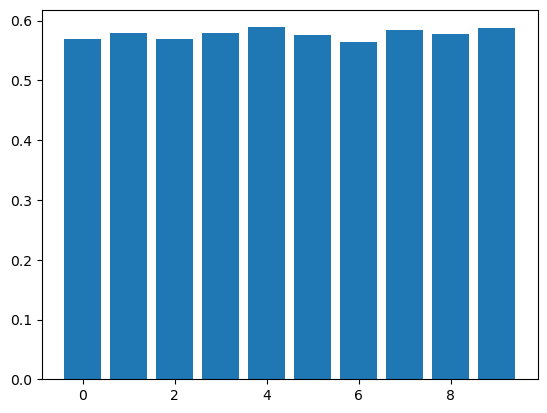

In [9]:
import matplotlib.pyplot as plt

print("Weight norm of each class part of classifier")
print(torch.sqrt(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1)))))

class_index=[i for i in range(num_classes)]

plt.bar(class_index, torch.sqrt(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1)))).cpu().detach().numpy())

plt.show()

# HeatMap of weight bias

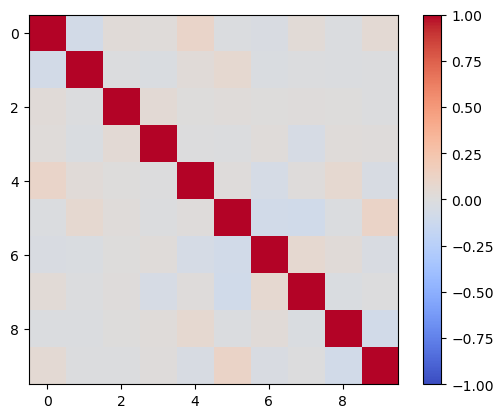

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 2D array로 변환
cos_sim_np = torch.mm(normalized_classifier, normalized_classifier.transpose(0,1)).cpu().detach().numpy()
# heatmap 그리기
plt.imshow(cos_sim_np, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

# Get a feature vector centroid and each centroid vector's norm and cosine similarity each other (Test Data)

In [11]:
                net_local_list[0].eval()
                
                label= [i for i in range(num_classes)]
                
                ldr_test = DataLoader(dataset_test, batch_size=args.local_bs, shuffle=False)
                class_sums = {i: None for i in label}
                class_counts = {i: None for i in label}



                with torch.no_grad():
                    for idx, (images, labels) in enumerate(ldr_test):
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = net_local_list[0].extract_features(images)

                        for i in range(len(label)):
                            class_mask = labels == label[i]  

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 해당
                                class_features = features[class_mask]
                                class_sum = class_features.sum(dim=0)
                                count=class_features.shape[0]

                                if class_sums[label[i]]== None and class_counts[label[i]] == None:
                                    class_sums[label[i]]=class_sum
                                    class_counts[label[i]]=count
                                else:
                                    class_sums[label[i]]+=class_sum
                                    class_counts[label[i]]+=count

                #Get the class-wise feature centroid                    
                class_mean_dict={}
                for key, value in class_sums.items():
                    if key in class_counts:
                        class_mean_dict[key] = value / class_counts[key]


                #Get a inner product of centroids

                cos_sim_hist={}

                with torch.no_grad():
                    inner_product_hist={key: 0 for key in class_mean_dict.keys()}
                    for images, labels in ldr_test:
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = net_local_list[0].extract_features(images)
                        for i in range(len(label)):

                            mean_feature=class_mean_dict[label[i]]

                            normalized_mean_feature=mean_feature/torch.norm(mean_feature)

                            class_mask = labels == label[i]  # "cat" 클래스의 마스크를 생성합니다.

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 평균 벡터를 계산합니다.
                                class_features = features[class_mask]
                                normalized_class_features=nn.functional.normalize(class_features, p=2, dim=1)

                                inner_product=torch.mm(normalized_class_features, normalized_mean_feature.unsqueeze(1))
                                if label[i] not in cos_sim_hist.keys():
                                    if class_features.shape[0]==1:
                                        cos_sim_hist[label[i]]=np.array([inner_product.squeeze().cpu().numpy()[()]])
                                    else:
                                        cos_sim_hist[label[i]]=inner_product.squeeze().cpu().numpy()
                                else:
                                    if class_features.shape[0]==1:
                                        cos_sim_hist[label[i]]=np.concatenate((cos_sim_hist[label[i]], np.array([inner_product.squeeze().cpu().numpy()[()]])), axis=0)

                                    else:
                                        cos_sim_hist[label[i]]=np.concatenate((cos_sim_hist[label[i]], inner_product.squeeze().cpu().numpy()), axis=0)

                                        
                cos_sim_mean={}
                cos_sim_var={}

                for key in class_sums.keys():
                    if key in class_counts:
                        cos_sim_mean[key] = cos_sim_hist[key].mean()
                        cos_sim_var[key] = cos_sim_hist[key].var()
                print("-------------------MEAN-------------------")                

                print(cos_sim_mean)
                print("-------------------VAR-------------------")                

                print(cos_sim_var)



-------------------MEAN-------------------
{0: 0.9717068, 1: 0.98182654, 2: 0.97804105, 3: 0.98391664, 4: 0.97748697, 5: 0.98424053, 6: 0.9820501, 7: 0.9832986, 8: 0.97878116, 9: 0.97556484}
-------------------VAR-------------------
{0: 0.0006720348, 1: 0.00096587755, 2: 0.00040073993, 3: 0.0003670756, 4: 0.0005973076, 5: 0.00031237147, 6: 0.00022764629, 7: 0.0005399356, 8: 0.00073657907, 9: 0.0013081131}


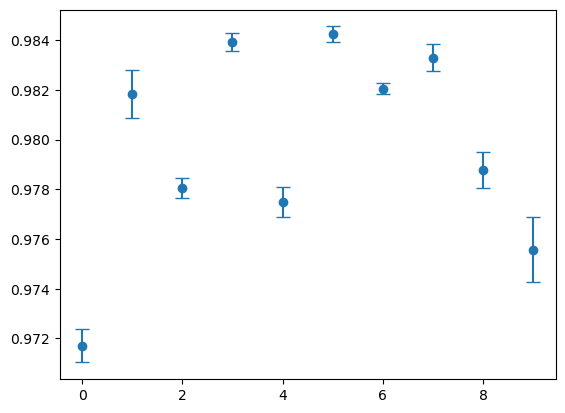

In [12]:
import matplotlib.pyplot as plt


class_index=[i for i in range(num_classes)]

#centroid로부터 cosine similarity 값들의 mean, variance
classwise_mean=list(cos_sim_mean.values())
classwise_var=list(cos_sim_var.values())

plt.errorbar(class_index, classwise_mean, classwise_var, fmt='o', capsize=5)

plt.show()

# Get a feature vector centroid and each centroid vector's norm and cosine similarity each other (Test Data)

In [13]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for shard_per_user in [2]:
    for frac in [0.1]:
        for local_ep in [15]:
            for local_upt_part, aggr_part in [('body', 'body')]:
                args = easydict.EasyDict({'epochs': local_ep,
                                          'num_users': 100,
                                          'shard_per_user': shard_per_user,
                                          'server_data_ratio': server_data_ratio,
                                          'frac': frac,
                                          'local_ep': local_ep,
                                          'local_bs': 500,
                                          'bs': 50,
                                          'lr': 0.01,
                                          'momentum': momentum,
                                          'wd': wd,
                                          'model': model,
                                          

                                          'dataset': dataset,
                                          'iid': False,
                                          'num_classes': num_classes,
                                          'gpu': 0,
                                          'verbose': False,
                                          'seed': 1,
                                          'test_freq': 1,
                                          'load_fed': '',
                                          'results_save': 'run1',
                                          'local_upt_part': local_upt_part,
                                          'aggr_part': aggr_part,
                                          'feature_norm': 1,
                                          'fn': False,
                                          'hetero_option': "shard"
                                          })

                # parse args
                args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
                base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/shard{}/decay_0.1/fn_{}/seed_0/FedAvg'.format(
                    args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd,args.shard_per_user, args.fn)
                algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)
                
 
                dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)
    
                dict_save_path = 'dict_users_10_{}.pkl'.format(args.shard_per_user)
                with open(dict_save_path, 'rb') as handle:#기존 pretrained되었을 때 쓰였던 클라이언트 구성으로 덮어씌운다.
                    dict_users_train, dict_users_test = pickle.load(handle)
    

                # build model
                net_glob = get_model(args)
                net_glob.train()
                

                net_local_list = []
                for user_ix in range(args.num_users):
                    net_local_list.append(copy.deepcopy(net_glob))

                criterion = nn.CrossEntropyLoss()

                before_acc_results = []#pretrained 모델에서의 모든 각 클라이언트의 test acc 기록!!
                after_acc_results = []
                
                for user, net_local in enumerate(net_local_list):
                    model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                    net_local.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                    acc_test, loss_test = test_img_local(net_local, dataset_test, args, user_idx=user, idxs=dict_users_test[user])
                    before_acc_results.append(acc_test)

                net_local_list[0].eval()
                
                label= [i for i in range(num_classes)]                    


                ldr_test = DataLoader(dataset_test, batch_size=args.local_bs, shuffle=False)
                class_sums = {i: None for i in label}
                class_counts = {i: None for i in label}



                with torch.no_grad():
                    for idx, (images, labels) in enumerate(ldr_test):
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = net_local_list[0].extract_features(images)

                        for i in range(len(label)):
                            class_mask = labels == label[i]  

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 해당
                                class_features = features[class_mask]
                                class_sum = class_features.sum(dim=0)
                                count=class_features.shape[0]

                                if class_sums[label[i]]== None and class_counts[label[i]] == None:
                                    class_sums[label[i]]=class_sum
                                    class_counts[label[i]]=count
                                else:
                                    class_sums[label[i]]+=class_sum
                                    class_counts[label[i]]+=count

                #Get the class-wise feature centroid                    
                class_mean_dict={}
                for key, value in class_sums.items():
                    if key in class_counts:
                        class_mean_dict[key] = value / class_counts[key]

                print(class_mean_dict)
                #Get a Inner product of each class's centroid vector

                sorted_keys=sorted(class_mean_dict)
                print(sorted_keys)

                class_mean_lst=[]


                for key in sorted_keys:
                    class_mean_lst.append(class_mean_dict[key])

                class_mean_lst=torch.stack(class_mean_lst)


                print(class_mean_lst.shape)
                print(class_mean_lst.transpose(0,1).shape)

                #Get the each centroid vector's norm
                print("-------------Norm of each centroid vectors --------------")
                print(torch.diagonal(torch.mm(class_mean_lst, class_mean_lst.transpose(0,1))))


                #Get the cosine similarity result between eacn centroid vectors


                normalized_class_mean_lst=nn.functional.normalize(class_mean_lst, p=2, dim=1)
                print("-------------Cosine similarity of Each Centroid vectors--------------")
                print(torch.mm(normalized_class_mean_lst, normalized_class_mean_lst.transpose(0,1)).cpu().numpy())
                    
                    
    


Files already downloaded and verified
Files already downloaded and verified
{0: tensor([3.3454e+00, 2.2419e+00, 0.0000e+00, 1.1019e+00, 0.0000e+00, 0.0000e+00,
        4.2650e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0566e+00,
        0.0000e+00, 2.5863e+00, 5.3556e-01, 1.1703e-03, 8.8381e-01, 5.7958e-01,
        1.9261e+00, 3.5542e+00, 0.0000e+00, 4.5534e+00, 1.7941e+00, 1.1063e+00,
        4.1642e+00, 2.8100e+00, 3.0232e+00, 5.8546e+00, 3.2019e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 8.2140e+00, 4.2336e+00, 1.2040e+00, 5.5878e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.8733e+00, 7.3357e+00, 1.3554e+00,
        0.0000e+00, 0.0000e+00, 2.6578e+00, 5.0750e+00, 0.0000e+00, 5.1915e+00,
        5.0855e+00, 5.0852e+00, 0.0000e+00, 0.0000e+00, 4.9852e+00, 4.7234e+00,
        0.0000e+00, 0.0000e+00, 2.6369e+00, 5.7619e+00, 1.2333e+00, 2.8469e-02,
        0.0000e+00, 4.4204e+00, 0.0000e+00, 2.4387e+00, 2.3883e+00, 2.5850e+00,
        5.9720e+00, 0.0000e+00, 0.0000e+

# Cosine Similarity of Centroid Vectors

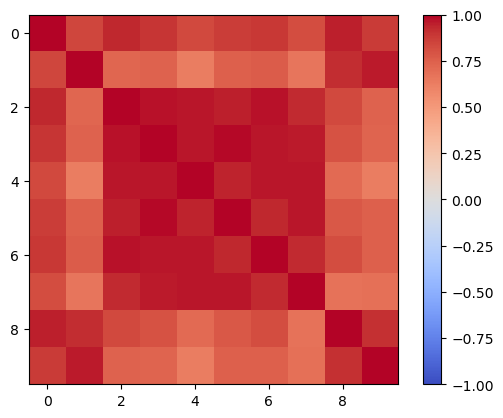

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 2D array로 변환
cos_sim_np = torch.mm(normalized_class_mean_lst, normalized_class_mean_lst.transpose(0,1)).cpu().numpy()
# heatmap 그리기
plt.imshow(cos_sim_np, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

In [15]:
print(type(cos_sim_np))

print(cos_sim_np)

print(cos_sim_np.sum(axis=1))

print(cos_sim_np.sum(axis=0))

<class 'numpy.ndarray'>
[[1.         0.83664185 0.93191814 0.8909315  0.83455735 0.86825883
  0.8900234  0.81736714 0.9495413  0.8768433 ]
 [0.83664185 1.         0.7261907  0.7411627  0.63199747 0.7424907
  0.76359206 0.6584366  0.9218572  0.9607461 ]
 [0.93191814 0.7261907  1.         0.9760186  0.9645819  0.9508741
  0.9694005  0.9285943  0.828287   0.7346934 ]
 [0.8909315  0.7411627  0.9760186  0.99999994 0.96223116 0.992108
  0.96556556 0.956645   0.8045162  0.73351103]
 [0.83455735 0.63199747 0.9645819  0.96223116 0.99999994 0.94159824
  0.9611431  0.96666104 0.7032277  0.6270823 ]
 [0.86825883 0.7424907  0.9508741  0.992108   0.94159824 1.0000001
  0.9343971  0.96403944 0.78008735 0.7435663 ]
 [0.8900234  0.76359206 0.9694005  0.96556556 0.9611431  0.9343971
  1.         0.922065   0.81776327 0.7426678 ]
 [0.81736714 0.6584366  0.9285943  0.956645   0.96666104 0.96403944
  0.922065   1.         0.6765097  0.68670434]
 [0.9495413  0.9218572  0.828287   0.8045162  0.7032277  0.780

# Centroid-Feature Alignment

In [16]:
print(torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))))

tensor([0.1759, 0.2667, 0.1423, 0.1158, 0.1642, 0.1470, 0.1577, 0.1740, 0.1817,
        0.2553], device='cuda:0', grad_fn=<DiagonalBackward0>)


Centroid-Feature Alignment of each class
tensor([0.1759, 0.2667, 0.1423, 0.1158, 0.1642, 0.1470, 0.1577, 0.1740, 0.1817,
        0.2553], device='cuda:0', grad_fn=<DiagonalBackward0>)


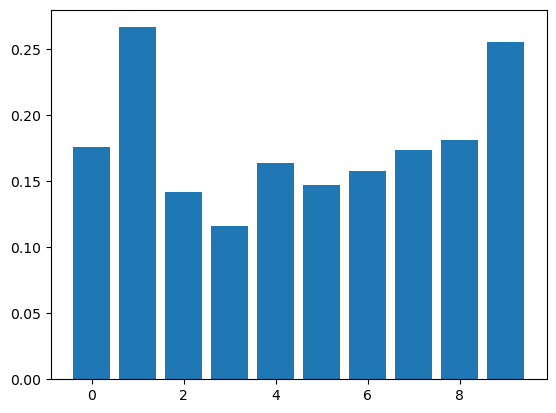

In [17]:
import matplotlib.pyplot as plt

print("Centroid-Feature Alignment of each class")
print(torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))))

class_index=[i for i in range(num_classes)]

plt.bar(class_index, torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))).cpu().detach().numpy())

plt.show()